# Integration of BAL samples (v8)

In [1]:
import scanpy as sc
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os

## Read in data

In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
in_dir = "01BAL/01integrated_BAL_v7"
in_name = "01integrated_BAL_v7"

adata = sc.read_h5ad(f"{data_dir}/{in_dir}/{in_name}.h5ad")
adata.obs.rename(columns = {"Study ID" : "Study_ID"}, inplace = True)

## Remove low quality clusters

In [4]:
adata = adata[~adata.obs["subcluster"].isin(['7', '11'])].copy()

## Remerge subclusters

Clusters 10-0 and 10-2 are both composed of DC2 cells. Clusters 14-0 and 14-2 are both classical monocytes.

In [5]:
adata.obs.subcluster[adata.obs.subcluster == "10-2"] = "10-0"
adata.obs.subcluster[adata.obs.subcluster == "14-2"] = "14-0"
adata.obs.subcluster = adata.obs.subcluster.cat.remove_unused_categories()

## Redo cell types

In [6]:
annotations = {"0-0" : "CD8 T cells - 0",
               "0-1" : "CD8 T cells - 1",
               "0-2" : "CD8 T cells - 2",
               "0-3" : "CD8 T cells - 3",
               "1-0" : "MoAMs - 0",
               "1-1" : "MoAMs - 1",
               "1-2" : "MoAMs - 2",
               "1-3" : "MoAMs - 3",
               "2-0" : "CD4 T cells - 0",
               "2-1" : "CD4 T cells - 1",
               "2-2" : "CD4 T cells - 2",
               "2-3" : "CD4 T cells - 3",
               "3" : "TRAM1",
               "4" : "TRAM2",
               "5" : "TRAM3",
               "6-0" : "MoAMs - 4",
               "6-1" : "Perivascular macrophages",
               "6-2" : "MoAMs - 5",
               "8-0" : "TRAM4 (SOD2, CCL3, CCL4)",
               "8-1" : "TRAM5 (MT1G)",
               "9-0" : "Proliferating TRAM",
               "9-1" : "Proliferating T cells",
               "10-0" : "DC2",
               "10-1" : "CCR7 migratory DC",
               "12" : "NK and gdT cells",
               "13" : "Tregs (FOXP3)",
               "14-0" : "Classical monocytes",
               "14-1" : "Non-classical monocytes",
               "15" : "B cells",
               "16" : "DC1",
               "17" : "pDC",
               "18" : "Mast cells",
               "19" : "Plasma cells",
               "20" : "Epithelial cells",
               "21" : "SARS-CoV-2"}
adata.obs["cell_type"] = adata.obs['subcluster'].map(annotations).astype('category')

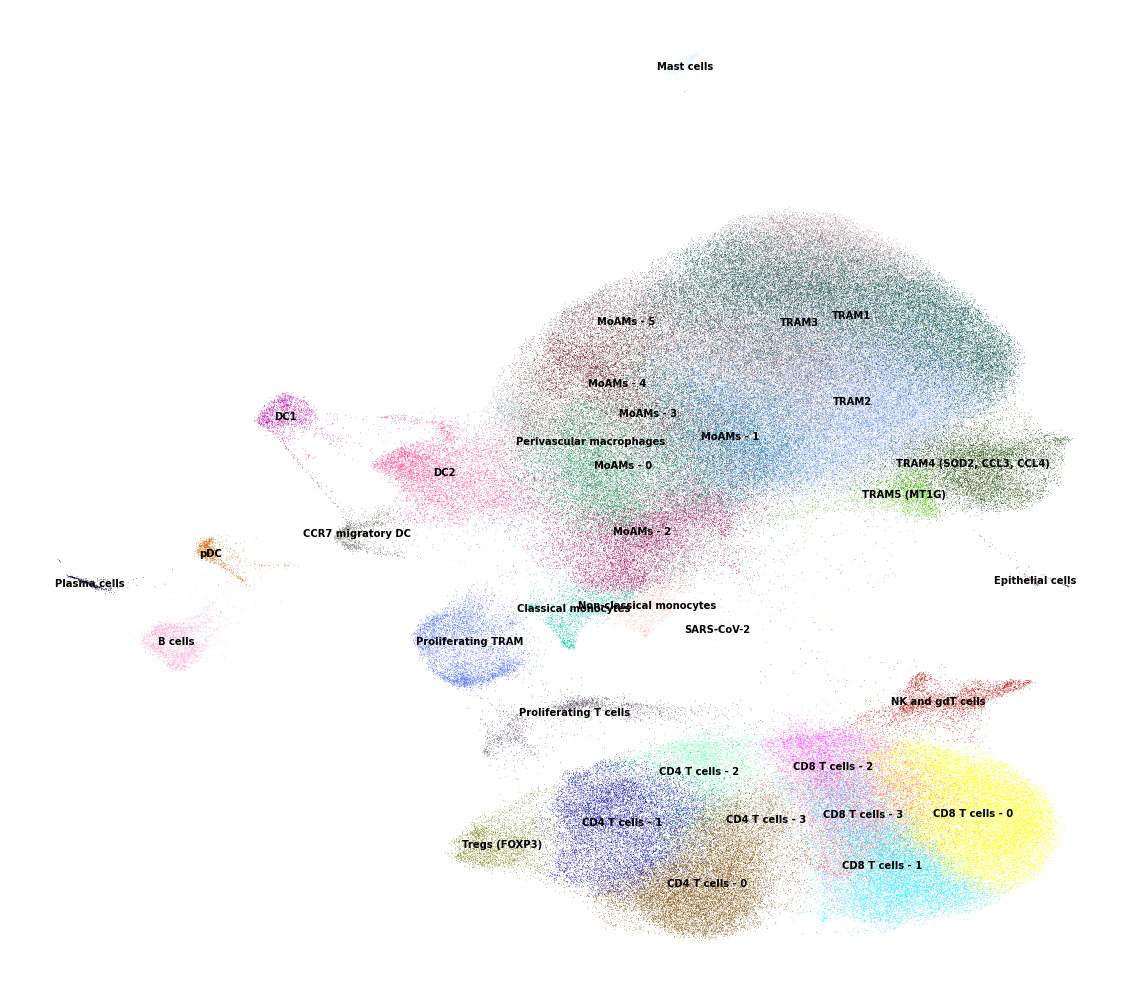

In [38]:
mpl.rcParams["figure.figsize"] = (20, 18)
ax = sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", frameon = False, title = "", size = 2)

## Recompute markers

In [39]:
adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, "cell_type", method = "wilcoxon", n_genes = 200)

/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/chp4225/.conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [42]:
markers = sc_utils.get_markers(adata, "cell_type")
pd.options.display.max_rows = 500
markers.groupby("cluster").apply(lambda x: x.sort_values("avg_logFC", ascending = False).head(5))

p_val  avg_logFC     pct.1     pct.2  \
cluster                                                                       
B cells                  5600   0.000000e+00  12.350911  0.924928  0.001229   
                         5601   0.000000e+00  10.100749  0.819484  0.002919   
                         5790   4.495443e-40   9.811037  0.187393  0.000465   
                         5617  3.597061e-270   9.586520  0.491117  0.003197   
                         5644  2.604130e-200   9.564064  0.422350  0.001718   
CCR7 migratory DC        4728  8.873329e-131  10.729577  0.445866  0.000818   
                         4629  9.122519e-297  10.595888  0.672244  0.001108   
                         4602   0.000000e+00   9.848015  0.901575  0.010221   
                         4601   0.000000e+00   9.042806  0.918307  0.010382   
                         4620   0.000000e+00   9.041011  0.724409  0.008262   
CD4 T cells - 0          1651   0.000000e+00   4.962194  0.423458  0.021663   
                         1600   0.000000e+00   3.847617  0.950634  0.268774   
                         1708   0.000000e+00   3.798785  0.309492  0.029205   
                         1699   0.000000e+00   3.160809  0.358236  0.056564   
                         1631   0.000000e+00   3.156130  0.547809  0.100086   
CD4 T cells - 1          1968  9.038905e-307   4.238192  0.223618  0.015886   
                         1977  5.150784e-262   4.104052  0.206900  0.014548   
                         1994  4.875531e-219   3.920508  0.192127  0.016714   
                         1804   0.000000e+00   3.665503  0.775144  0.244553   
                         1938   0.000000e+00   3.195513  0.275807  0.035888   
CD4 T cells - 2          2072   2.647120e-30   3.962707  0.112896  0.013807   
                         2165   2.307131e-08   3.962387  0.056558  0.006505   
                         2195   1.166131e-05   3.624405  0.050176  0.010397   
                         2186   2.345624e-06   3.149685  0.052377  0.009673   
                         2148   4.753329e-10   3.124014  0.068222  0.013091   
CD4 T cells - 3          2377   1.684245e-29   6.597105  0.186170  0.002264   
                         2295   2.677060e-86   5.918183  0.324468  0.007025   
                         2201   0.000000e+00   5.128078  0.785714  0.070274   
                         2312   1.261856e-66   4.509176  0.295593  0.018134   
                         2341   5.575537e-41   4.372618  0.233283  0.016984   
CD8 T cells - 0          0      0.000000e+00   5.122936  0.977726  0.212314   
                         14     0.000000e+00   5.066610  0.683191  0.047709   
                         26     0.000000e+00   4.676886  0.652452  0.050945   
                         2      0.000000e+00   4.458668  0.791651  0.079399   
                         16     0.000000e+00   4.281782  0.699275  0.068002   
CD8 T cells - 1          209    0.000000e+00   5.240547  0.639071  0.041868   
                         200    0.000000e+00   4.974514  0.980300  0.231959   
                         201    0.000000e+00   4.869130  0.904472  0.143023   
                         211    0.000000e+00   4.268078  0.651266  0.071634   
                         379   3.669833e-270   4.082749  0.198405  0.014272   
CD8 T cells - 2          401    0.000000e+00   3.815477  0.874569  0.255972   
                         464   1.936136e-120   3.744922  0.205720  0.030375   
                         439   6.962025e-186   3.574310  0.259649  0.043542   
                         573    3.237088e-18   3.547474  0.079600  0.012222   
                         413    0.000000e+00   3.410115  0.412819  0.077944   
CD8 T cells - 3          600    0.000000e+00   4.118191  0.958520  0.258461   
                         784    1.059893e-84   3.541160  0.196795  0.022341   
                         606    0.000000e+00   3.537881  0.760311  0.172103   
                         616    0.000000e+00   3.524141  0.672637  0.106249   
          

## Save output

In [ ]:
out_dir = "01BAL/01integrated_BAL_v8"
out_name = "01integrated_BAL_v8"

adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")
markers.to_csv(f"{data_dir}/{out_dir}/{out_name}-markers.csv")